Hubbard Model 1D Chain DQMC

### The Hamiltonian

The Hamiltonian of the Fermi-Hubbard model is described by $\hat{H}=\hat{K}+\hat{V}$ 

where $\hat{K} = -\sum_{ij\sigma}t_{ij}(c_{i\sigma}^\dagger c_{j\sigma} + c_{j\sigma}^\dagger c_{i\sigma}) -\mu \sum_{i\sigma}n_{i\sigma}$, 

and $\hat{V} = U\sum_i (n_{i\uparrow}-\frac{1}{2})(n_{i\downarrow}-\frac{1}{2})$

We are simulating a 1D periodic chain with N sites. We are using the inverse temperature, $\beta=\frac{1}{T} = L\Delta \tau$ which is divided into L "imaginary time intervals" with an interval length of $\Delta \tau$. We also want to make sure that $tU(\Delta\tau)^2<\frac{1}{10}$, or $\Delta\tau<\frac{1}{\sqrt{10tU}}$. 


In [114]:
import numpy as np # For arrays and math calculations
import matplotlib.pyplot as plt # For plotting
import numba # for JIT compilation
import pandas as pd # For loading CSV files from SmoQy
import os # For checking if SmoQyDQMC folders exist so we can skip regenerating data
from scipy.linalg import expm # For matrix exponential

### The Kinetic Energy Matrix

First we begin by calculating the $\hat{K}$ matrix. We expect to see $\Delta\tau$ multiplying the entire matrix, and in the matrix we should see $-\mu$ on the diagonal and a $t$ to the left and right of every diagonal element (from the hopping term).


In [120]:
@numba.njit
def generate_kinetic_energy_matrix(N, t, mu, delta_tau):
    """
    Generate the kinetic energy matrix for DQMC.
    We need eigenvalues of K to be (epsilon_k - mu) so that:
    G = [I + exp(-beta*K)]^{-1} and n = 1-G gives Fermi-Dirac distribution
    
    For 1D chain: epsilon_k from hopping are in [-2t, 2t]
    We want K eigenvalues = epsilon_k - mu
    So K = H_hopping - mu*I where H_hopping has eigenvalues epsilon_k

    Parameters:
    N (int): Number of lattice sites
    t (float): Hopping parameter  
    mu (float): Chemical potential
    delta_tau (float): Discretization step

    Returns:
    numpy.ndarray: The kinetic energy matrix K times delta_tau.
    """
    # Initialize the matrix
    k_matrix = np.zeros((N,N))

    # Fill the matrix: K = (hopping) - mu*I
    # For tight-binding, hopping matrix has +t on off-diagonals (standard convention)
    for i in range(N):
        # Diagonal term: -mu 
        k_matrix[i, i] = -mu

        # Off-diagonal hopping: +t (standard tight-binding)
        k_matrix[(i+1)%N, i] = t  
        k_matrix[(i-1)%N, i] = t  

    # Scale the matrix by delta_tau
    k_matrix *= delta_tau

    return k_matrix

### The Interaction Energy Matrix 

Next we can create the Interaction Energy Matrix. We first want to create an $NxL$ array $s(i,l)$ filled randomly with $\pm1$ which represents the Hubbard-Stratonovich field 

Then we make a series of L $NxN$ diagonal matrices. These will be $v_\uparrow(l=0),v_\uparrow(l=1)...v_\uparrow(l=L)$. We also have matrices for spin-down electrons where $v_\downarrow(l) = -v_\uparrow(l)$. Each $v$ matrix is multiplied by a factor of $\lambda$, given by $cosh(\lambda) = e^{\frac{U\Delta\tau}{2}}$


In [121]:
@numba.njit
def generate_interaction_energy_matrix(N, L, U, delta_tau, s=None):
    """
    Generate the interaction energy matrices v_up(l) and v_down(l)
    
    Parameters:
        N (int): Number of sites (dimension of the matrix)
        L (int): Number of time slices
        U (float): Interaction energy
        delta_tau (float): Discretization parameter
    
    Returns:
        tuple: Two 3D arrays (v_up, v_down), s matrix, and varlambda
    """

    # Create s(i,l) matrix
    if s is None:
        # Generate -1 and 1 values using randint
        s = np.random.randint(0, 2, size=(N, L)) * 2 - 1

    # Calculate lambda
    varlambda = np.arccosh(np.exp(U * delta_tau / 2))

    # Preallocate v_ups and v_downs
    v_ups = np.zeros((L, N, N))
    v_downs = np.zeros((L, N, N))

    # Fill v_ups and v_downs
    for l in range(L):
        for i in range(N):
            v_ups[l, i, i] = varlambda * s[i, l]
            v_downs[l, i, i] = -varlambda * s[i, l]

    return v_ups, v_downs, s, varlambda

### Initializing the Green's Function

To initialize the Green's Function we need to compute it for up and down:

$G_\sigma = [ I +e^ke^{v_\sigma(1)}e^ke^{v_\sigma(2)}....e^ke^{v_\sigma(L)}]^{-1}$

$G_\sigma = [ I +e^{kL}e^{v_\sigma(1)+v_\sigma(2)+...v_\sigma(L)}]^{-1}$

k is diagonalized so we can pull it out and multiply by L

In [122]:
@numba.njit
def generate_greens_function_matrix_numba(k_matrix, L, N):
    """Helper function for matrix exponential computation (diagonal case only)"""
    I = np.eye(N)
    e_kL = np.exp(-L*k_matrix)  # Only works if k_matrix is diagonal
    G = np.linalg.solve(I + e_kL, I)
    return G

def generate_greens_function_matrix(k_matrix, v_ups, v_downs, L, N):
    """
    Generate the Green's function matrix G(i,j) for a 1D Hubbard model
    G = [I + B]^{-1} where B = exp(-beta*K) in DQMC formulation (for U=0)
    
    IMPORTANT: k_matrix must be the FULL matrix, not diagonalized!
    We use scipy.linalg.expm for proper matrix exponential.

    Parameters:
    k_matrix (numpy.ndarray): The kinetic energy matrix (FULL matrix, not diagonal)
    v_ups (numpy.ndarray): Array of the interaction energy matrices for spin up
    v_downs (numpy.ndarray): Array of the interaction energy matrices for spin down
    L (int): Number of imaginary time slices

    Returns:
    tuple: Two matrices (G_up, G_down), each of size NxN representing the up and down Green's functions matrices
    """
    
    I = np.eye(N)
    
    # For DQMC: B = exp(-L*k_matrix) 
    # Use matrix exponential (expm), NOT element-wise exponential (exp)!
    from scipy.linalg import expm
    e_kL = expm(-L*k_matrix)
    
    # The Green's function is G = [I + B]^{-1}
    G_up = np.linalg.solve(I + e_kL, I)
    G_down = np.linalg.solve(I + e_kL, I)

    return G_up, G_down

### Updating the Green's Function

We want to suggest a change in the Hubbard-Stratonovich field on site $i=1$ of imaginary time slice $l=L$

First we compute $d$:

$d_\uparrow = 1 + (1-[G_{\uparrow}]_{ii})(e^{-2\lambda s(i,l)}-1)$

$d_\downarrow = 1 + (1-[G_{\downarrow}]_{ii})(e^{+2\lambda s(i,l)}-1)$

$d = d_\uparrow d_\downarrow$

Then we draw a random number $0<r<1$. If $r<d$ then we set $s(i,l) = -s(i,l)$ 

In [123]:
def update_greens_function(G_up,G_down,k_matrix,v_ups,v_downs,varlambda,s,i,l,N,L,U,delta_tau):
    """
    Update the Green's function matrix G(i,j) for a 1D Hubbard model with periodic boundary conditions

    Parameters:
    G_up (numpy.ndarray): The Green's function matrix for spin up
    G_down (numpy.ndarray): The Green's function matrix for spin down
    k_matrix (numpy.ndarray): The kinetic energy matrix
    v_ups (numpy.ndarray): Array of the interaction energy matrices for spin up
    v_downs (numpy.ndarray): Array of the interaction energy matrices for spin down
    varlambda (float): The lambda parameter
    s (numpy.ndarray): The Hubbard-Stratonovich field
    i (int): Site index
    l (int): Time slice index
    N (int): Number of sites
    L (int): Number of time slices
    U (float): Interaction energy
    delta_tau (float): Imaginary time interval

    Returns:
    tuple: Two lists of matrices (G_up, G_down) each of size NxN representing the up and down Green's functions matrices
    """

    ### Propose a change to the Hubbard-Stratonovich field s(i,l)

    # First we calculate d_up, d_down
    d_up = 1 + (1-G_up[i,i])*(np.exp(-2*varlambda*s[i,l])-1)
    d_down = 1 + (1-G_down[i,i])*(np.exp(2*varlambda*s[i,l])-1)
    d = d_up*d_down

    # Draw a random number, if it is smaller than d, accept the move
    if np.random.rand() < d:
        s[i,l] *= -1 # Flip the sign of s(i,l)

        ### Update the Green's function matrix if s was updated 
        ### Note: This is the slower method O(N^3), a faster O(N^2) method is mentioned in the notes.
        v_ups, v_downs, s, varlambda = generate_interaction_energy_matrix(N, L, U, delta_tau, s=s) # Calculate new energy interaction matrices based on new s
        G_up, G_down = generate_greens_function_matrix(k_matrix, v_ups, v_downs,L,N) # calculate new Green's functions based on new v_ups and v_downs

    return G_up, G_down, s, v_ups, v_downs

### Wrapping the Green's Function

We iterate through $l$ for each $i$. After completion of one loop of $i$ s, we change the Green's functions as follows:

$G_\sigma = [e^k e^{v_\sigma(l)}] G_\sigma [e^k e^{v_\sigma (l)}]^{-1}$

We use np.linalg.inv() to find the inverse, and @ for the matrix algebra. 

In [124]:
def wrap_greens_function(k_matrix, v_ups, v_downs, l, G_up, G_down):
    """
    Wrap Green's function after sweeping through time slice l.
    Uses matrix exponential (expm) instead of element-wise exp.
    """
    from scipy.linalg import expm
    I = np.eye(N)
    
    # Use matrix exponential, not element-wise!
    e_kl_up = expm(-k_matrix + v_ups[l])
    e_kl_down = expm(-k_matrix + v_downs[l])
    
    G_up =  e_kl_up @ G_up @ np.linalg.solve(e_kl_up, I)
    G_down = e_kl_down @ G_down @ np.linalg.solve(e_kl_down, I)
    return G_up, G_down

### Measurements

Next we measure the observables using the following equations

**Density of electrons of spin $\sigma$ on site $i$:** $\langle n_{i\sigma} \rangle = 1- [G_\sigma]_{ii}$

**Double occupancy rate on site $i$:** $\langle n_{i\uparrow}n_{i\downarrow} \rangle = (1-[G_\uparrow]_{ii})(1-[G_\downarrow]_{ii})$

**Local moment on site $i$:** $\langle (n_{i\uparrow} - n_{i\downarrow})^2 \rangle = \langle n_{i\uparrow} + n_{i\downarrow} \rangle - 2\langle n_{i\uparrow} n_{i\downarrow} \rangle$ 

**Correlation between moments on sites $i,j$ where $i\neq j$**: 

$S_{+i} = c_{i\uparrow}^\dagger c_{i\downarrow}$, 

$S_{-j} = c_{j\downarrow}^\dagger c_{j\uparrow}$,

$\langle S_{+i}S_{-j} \rangle = -[G_\uparrow]_{ji} [G_\downarrow]_{ij}$

We will also set up bins so that we can calculate error bars

In [125]:
def calculate_observables(G_up, G_down, N):
    """
    Calculate the observables for a 1D Hubbard model with periodic boundary conditions

    Parameters:
    G_up (numpy.ndarray): The Green's function matrix for spin up
    G_down (numpy.ndarray): The Green's function matrix for spin down

    Returns:
    tuple: The average density per site n, average double occupancy rate per site db_occ, average local moment per site, moment correlation, and average sign
    """

    # Calculate the density
    densities_up = np.zeros(N)
    densities_down = np.zeros(N)
    for i in range(N):
        densities_up[i] = 1-G_up[i,i]
        densities_down[i] = 1-G_down[i,i]

    n_up = np.mean(densities_up)
    n_down = np.mean(densities_down)

    # Calculate the double occupancy rate
    double_occ = np.mean(densities_up*densities_down)

    # Calculate the local moment
    M_Z = np.mean(densities_up + densities_down - 2*densities_up*densities_down)

    M_Z_sqrd = 0.0
    for i in range(N):
        for j in range(N):
            if i == j:
                term = G_down[i,i] + G_up[i,i] - 2*G_up[i,i]*G_down[i,i]
            else:
                term = (G_up[i,i]*G_up[j,j] - G_up[i,j]*G_up[j,i] 
                    + G_down[i,i]*G_down[j,j] - G_down[i,j]*G_down[j,i] 
                    - G_up[i,i]*G_down[j,j] - G_down[i,i]*G_up[j,j])
            M_Z_sqrd += term
    
    # Calculate average sign (for fermion sign problem)
    # Sign = det(I + B_up) * det(I + B_down)
    # Since G = (I + B)^{-1}, we have det(I + B) = 1/det(G)
    sign_up = np.sign(np.linalg.det(G_up))
    sign_down = np.sign(np.linalg.det(G_down))
    avg_sign = sign_up * sign_down

    return n_up, n_down, double_occ, M_Z, M_Z_sqrd, avg_sign

In [126]:
@numba.njit
def bins(data,Nperbin,Nbins):
    '''
    Take data from a bin and calculate the average and error bars

    Paramters:
    data (numpy.ndarray): The data to be binned
    Nperbin (int): Number of measurements per bin
    Nbins (int): Number of bins
    
    Returns:
    tuple: The average (float) and error bar (float) of the data
    '''

    if Nbins != len(data):
        print('Check array size')
        return 0.0, 0.0

    Bin_avgs = data / Nperbin # normalize by number of measurements per bin

    Bin_totalavg=np.mean(Bin_avgs) # calculate the average across bins

    #This is where we calculate the error bars
    ErrorBars=0
    for i in range(Nbins):
        ErrorBars+=(Bin_avgs[i]-Bin_totalavg)**2
    ErrorBars=np.sqrt(1/Nbins)*np.sqrt(1/(Nbins-1))*np.sqrt(ErrorBars)

    return Bin_totalavg,ErrorBars

### Full Monte Carlo

In [108]:
wusweeps = 100 # Number of warm-up sweeps
msweeps = 100 # Number of measurement sweeps
skip = 0 # Skip measurements to avoid autocorrelation
bincount = 0 # Counter for binning
Nperbin = 10 # Number of measurements per bin
Nbins=msweeps//(Nperbin*(skip+1))

N = 6
t = 1.0  # Hopping parameter
U = 1.0  # On-site interaction energy
beta = 1.0  # Inverse temperature beta
delta_tau = 0.1  # Imaginary time interval
mu_i = -10.0  # Initial chemical potential
mu_f = 10.0  # Final chemical potential
mu_step = 2  # Step size for chemical potential
mus = np.arange(mu_i, mu_f + mu_step, mu_step)  # Chemical potential values
sID = 1  # Simulation ID number for saving data

# Create empty bins for the observables
n_up_bins = np.zeros(Nbins)
n_down_bins = np.zeros(Nbins)
double_occ_bins = np.zeros(Nbins)
mz_bins = np.zeros(Nbins)

if os.path.exists("data") == False: # Check if the data folder exists
    os.makedirs("data") # Create the data folder if it doesn't exist

In [109]:
def run_dqmc_parameter(N, t, U, beta, delta_tau, mu, wusweeps, msweeps, skip, Nperbin, Nbins):
    '''Run the DQMC simulation for given parameters and return the observables.
    
    Uses sign reweighting: observables are multiplied by sign during accumulation,
    then divided by average sign at the end for numerical stability.
    '''
    bincount = 0
    print(f' Running simulation for Mu={mu}, Beta={beta}, U={U}, N={N}...')

    # Bins for sign-weighted observables
    n_up_bins = np.zeros(Nbins)
    n_down_bins = np.zeros(Nbins)
    double_occ_bins = np.zeros(Nbins)
    mz_bins = np.zeros(Nbins)
    mz_sqrd_bins = np.zeros(Nbins)

    # Separate bin for the sign itself (not weighted)
    avg_sign_bins = np.zeros(Nbins)

    # Generate the initial matrices for Kinetic Energy and Interaction Energy
    k_matrix = generate_kinetic_energy_matrix(N, t, mu, delta_tau)
    
    L = int(beta/delta_tau)
    # Check that beta is divisible by delta_tau
    if not np.isclose(beta, L * delta_tau, rtol=1e-12, atol=1e-15):
        raise ValueError("beta must be divisible by delta_tau to get an integer number of time slices L.")

    v_ups, v_downs, s, varlambda = generate_interaction_energy_matrix(N, L, U, delta_tau, s=None)
    
    G_up, G_down = generate_greens_function_matrix(k_matrix, v_ups, v_downs, L, N)

    for j in range(wusweeps): # warm-up sweeps
        for l in range(L-1,-1,-1): 
            for i in range(N):
                G_up, G_down, s, v_ups, v_downs = update_greens_function(G_up, G_down, k_matrix, v_ups, v_downs, varlambda, s, i, l, N, L, U, delta_tau)
            G_up, G_down = wrap_greens_function(k_matrix, v_ups, v_downs, l, G_up, G_down)

    for j in range(msweeps*(1+skip)): # Measurement sweeps
        for l in range(L-1,-1,-1):
            for i in range(N):
                G_up, G_down, s, v_ups, v_downs = update_greens_function(G_up, G_down, k_matrix, v_ups, v_downs, varlambda, s, i, l, N, L, U, delta_tau)
            G_up, G_down = wrap_greens_function(k_matrix, v_ups, v_downs, l, G_up, G_down)

        if skip == 0 or j%skip == 0: # Skip measurements to avoid autocorrelation
            n_up, n_down, double_occ, mz, mz_sqrd, avg_sign = calculate_observables(G_up, G_down, N)
            
            # Sign reweighting: multiply observables by sign before accumulating
            n_up_bins[bincount] += n_up * avg_sign
            n_down_bins[bincount] += n_down * avg_sign
            double_occ_bins[bincount] += double_occ * avg_sign
            mz_bins[bincount] += mz * avg_sign
            mz_sqrd_bins[bincount] += mz_sqrd * avg_sign

            # Accumulate sign separately (not weighted by itself)
            avg_sign_bins[bincount] += avg_sign

            bincount = (bincount+1)%Nbins

    # Process bins - get average sign first
    avg_sign_val, avg_sign_err = bins(avg_sign_bins, Nperbin, Nbins)
    
    # For observables, compute binned averages then divide by average sign (reweighting)
    # This properly handles the sign problem when avg_sign < 1
    if np.abs(avg_sign_val) > 1e-10:  # Avoid division by zero
        # Compute weighted averages and errors
        n_up_weighted, n_up_weighted_err = bins(n_up_bins, Nperbin, Nbins)
        n_down_weighted, n_down_weighted_err = bins(n_down_bins, Nperbin, Nbins)
        double_occ_weighted, double_occ_weighted_err = bins(double_occ_bins, Nperbin, Nbins)
        mz_weighted, mz_weighted_err = bins(mz_bins, Nperbin, Nbins)
        mz_sqrd_weighted, mz_sqrd_weighted_err = bins(mz_sqrd_bins, Nperbin, Nbins)
        
        # Divide by average sign to get reweighted observables
        n_up_val = n_up_weighted / avg_sign_val
        n_down_val = n_down_weighted / avg_sign_val
        double_occ_val = double_occ_weighted / avg_sign_val
        mz_val = mz_weighted / avg_sign_val
        mz_sqrd_val = mz_sqrd_weighted / avg_sign_val

        # Error propagation for O_reweighted = O_weighted / <sign>
        # Using: err(A/B) ≈ |A/B| * sqrt((err_A/A)^2 + (err_B/B)^2)
        n_up_err = np.abs(n_up_val) * np.sqrt(
            (n_up_weighted_err/n_up_weighted)**2 if n_up_weighted != 0 else 0 + 
            (avg_sign_err/avg_sign_val)**2
        )
        n_down_err = np.abs(n_down_val) * np.sqrt(
            (n_down_weighted_err/n_down_weighted)**2 if n_down_weighted != 0 else 0 + 
            (avg_sign_err/avg_sign_val)**2
        )
        double_occ_err = np.abs(double_occ_val) * np.sqrt(
            (double_occ_weighted_err/double_occ_weighted)**2 if double_occ_weighted != 0 else 0 + 
            (avg_sign_err/avg_sign_val)**2
        )
        mz_err = np.abs(mz_val) * np.sqrt(
            (mz_weighted_err/mz_weighted)**2 if mz_weighted != 0 else 0 + 
            (avg_sign_err/avg_sign_val)**2
        )

        mz_sqrd_err = np.abs(mz_sqrd_val) * np.sqrt(
            (mz_sqrd_weighted_err/mz_sqrd_weighted)**2 if mz_sqrd_weighted != 0 else 0 + 
            (avg_sign_err/avg_sign_val)**2
        )
    else:
        # Sign is too small - severe sign problem, results unreliable
        print(f"WARNING: Average sign = {avg_sign_val:.2e} is too small! Results unreliable.")
        n_up_val = n_down_val = double_occ_val = mz_val = mz_sqrd_val = 0.0
        n_up_err = n_down_err = double_occ_err = mz_err = mz_sqrd_err = 0.0

    return np.array([n_up_val, n_up_err, n_down_val, n_down_err,
                     double_occ_val, double_occ_err,
                     mz_val, mz_err,
                     mz_sqrd_val, mz_sqrd_err,
                     avg_sign_val, avg_sign_err])

In [110]:
def run_dqmc_simulation(N, t, U, beta, delta_tau, mus, wusweeps, msweeps, skip, Nperbin, Nbins):
    results = {
        'n_up': np.zeros((2,len(mus))),
        'n_down': np.zeros((2,len(mus))),
        'double_occ': np.zeros((2,len(mus))),
        'mz': np.zeros((2,len(mus))),
        'mz_sqrd': np.zeros((2,len(mus))),
        'avg_sign': np.zeros((2,len(mus)))}
    
    for i, mu in enumerate(mus):
        run_result = run_dqmc_parameter(N, t, U, beta, delta_tau, mu, wusweeps, msweeps, skip, Nperbin, Nbins)
        results['n_up'][0,i] = run_result[0]
        results['n_up'][1,i] = run_result[1]
        results['n_down'][0,i] = run_result[2]
        results['n_down'][1,i] = run_result[3]
        results['double_occ'][0,i] = run_result[4]
        results['double_occ'][1,i] = run_result[5]
        results['mz'][0,i] = run_result[6]
        results['mz'][1,i] = run_result[7]
        results['mz_sqrd'][0,i] = run_result[8]
        results['mz_sqrd'][1,i] = run_result[9]
        results['avg_sign'][0,i] = run_result[10]
        results['avg_sign'][1,i] = run_result[11]

    return results


In [111]:
results = run_dqmc_simulation(N, t, U, beta, delta_tau, mus, wusweeps, msweeps, skip, Nperbin, Nbins)

 Running simulation for Mu=-10.0, Beta=1.0, U=1.0, N=6...
 Running simulation for Mu=-8.0, Beta=1.0, U=1.0, N=6...
 Running simulation for Mu=-6.0, Beta=1.0, U=1.0, N=6...
 Running simulation for Mu=-4.0, Beta=1.0, U=1.0, N=6...
 Running simulation for Mu=-2.0, Beta=1.0, U=1.0, N=6...
 Running simulation for Mu=0.0, Beta=1.0, U=1.0, N=6...
 Running simulation for Mu=2.0, Beta=1.0, U=1.0, N=6...
 Running simulation for Mu=4.0, Beta=1.0, U=1.0, N=6...
 Running simulation for Mu=6.0, Beta=1.0, U=1.0, N=6...
 Running simulation for Mu=8.0, Beta=1.0, U=1.0, N=6...
 Running simulation for Mu=10.0, Beta=1.0, U=1.0, N=6...


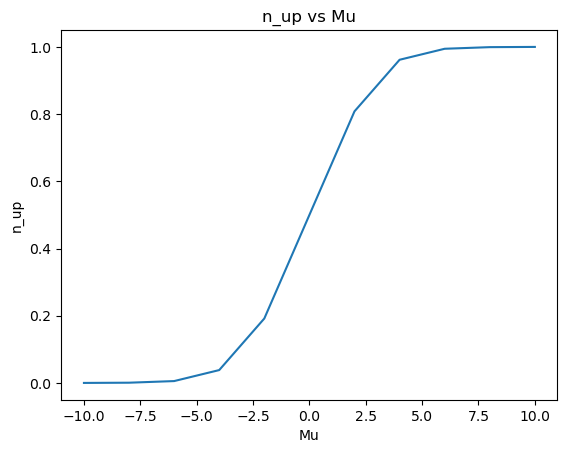

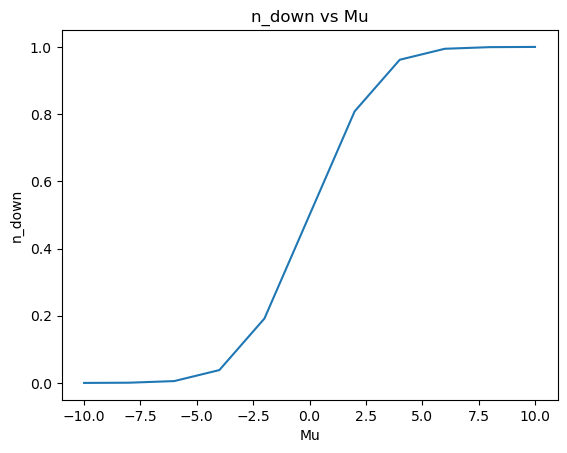

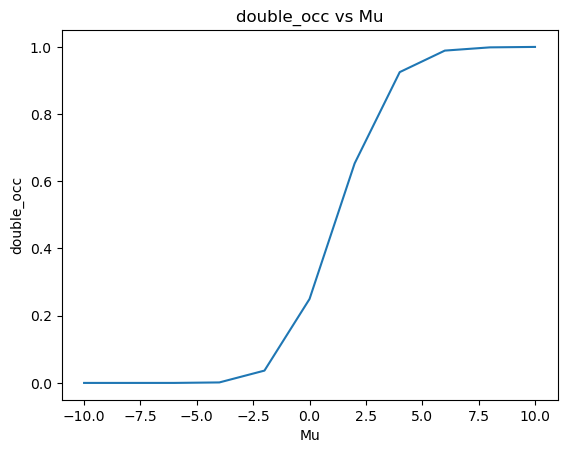

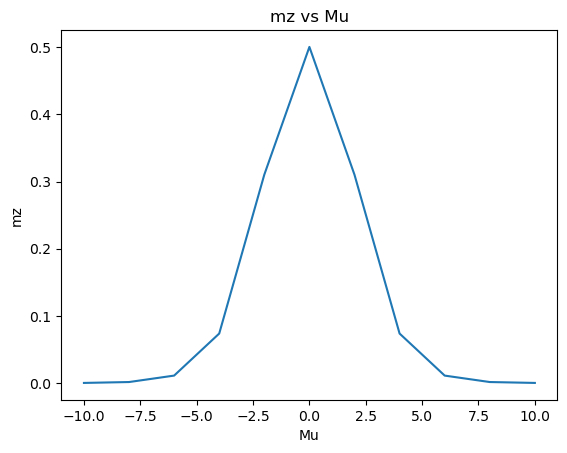

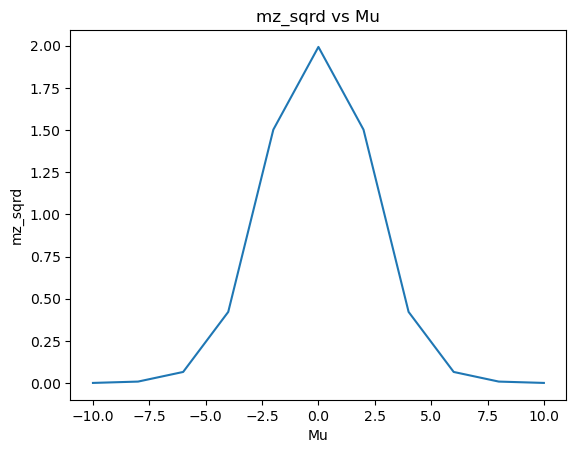

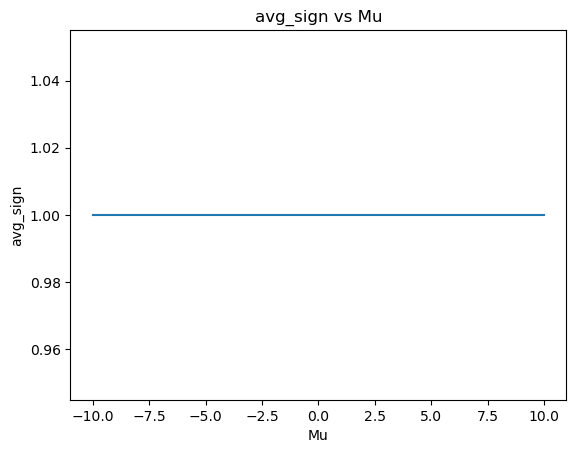

In [112]:
observables = ['n_up', 'n_down', 'double_occ', 'mz', 'mz_sqrd', 'avg_sign']
for obs in observables:
    plt.errorbar(mus, results[obs][0], yerr = results[obs][1])
    plt.title(f'{obs} vs Mu')
    plt.xlabel('Mu')
    plt.ylabel(obs)
    plt.show()